# Image compression with K-means

[K-means](https://en.wikipedia.org/wiki/K-means_clustering) is a [clustering](https://en.wikipedia.org/wiki/Cluster_analysis) algorithm which defines K cluster centroids in the feature space and, by making use of an appropriate distance function, iteratively assigns each example to the closest cluster centroid and each cluster centroid to the mean of points previously assigned to it.

In the following example we will make use of K-means clustering to reduce the number of colors contained in an image stored using 24-bit RGB encoding.

## Overview

The [RGB color model](https://en.wikipedia.org/wiki/RGB_color_model) is an additive color model in which red, green and blue light are added together in various ways to reproduce a broad array of colors. In a 24-bit encoding, each pixel is represented as three 8-bit unsigned integers (ranging from 0 to 255) that specify the red, green and blue intensity values, resulting in a total of 256\*256\*256=16,777,216 possible colors.


![uncompressed](media/uncompressed.png)

To compress the image, we will reduce this number to 16, assign each color to an index and then each pixel to an index. This process will significantly decrease the amount of space occupied by the image, at the cost of introducing some computational effort.

![compressed](media/compressed.png)

For a 128x128 image:
* Uncompressed format: 16,384 px \* 24 bits/px = 393,216 bits
* Compressed format: 16,384 px \* 4 bits/px + 16 clusters \* 24 bits/cluster = 65,536 + 385 bits = 65,920 bits (17%)

Note that we won't implement directly the K-means algorithm, as we are primarily interested in showing its application in a common scenario, but we'll delegate it to the [scikit-learn](http://scikit-learn.org) library.

## Implementation

### Import

First, let's import the image with scipy:

In [165]:
from scipy import misc
pic = misc.imread('media/irobot.png')

Note that [PIL](https://pypi.python.org/pypi/PIL) (or [Pillow](https://pypi.python.org/pypi/Pillow)) library is also needed to successfully import the image, so pip install it if you have not it installed.

Now let's take a look at the image by plotting it with matplotlib:

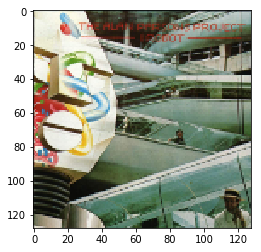

In [166]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(pic)

The image is stored in a 3-dimensional matrix, where the first and second dimension represent the pixel location on the 2-dimensional plan and the third dimension the RGB intensities:

In [167]:
pic.shape

(128, 128, 3)

### Preprocessing

We want to flatten the matrix, in order to give it to the clustering algorithm:

In [168]:
w = pic.shape[0]
h = pic.shape[1]
X = pic.reshape((w*h,3))
X.shape

(16384, 3)

### Fitting

Now by fitting the KMeans _estimator_ in scikit-learn we can identify the best clusters for the flattened matrix:

In [169]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=16)

kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=16, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

We can verify that each pixel has been assigned to a cluster:

In [170]:
kmeans.labels_

array([ 9,  0,  8, ...,  4, 14, 14], dtype=int32)

In [171]:
np.unique(kmeans.labels_)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15], dtype=int32)

And we can visualize each cluster centroid:

In [172]:
kmeans.cluster_centers_

array([[ 215.68088737,  215.16467577,  198.89590444],
       [  92.60763268,  125.60882528,  104.509839  ],
       [  49.42909357,   46.14619883,   28.19590643],
       [ 115.43900848,  139.11350294,  122.28571429],
       [ 138.41383423,  155.65414431,  141.03935599],
       [  64.43576389,   78.39409722,   51.81597222],
       [ 177.38596491,   58.38596491,   47.3245614 ],
       [ 195.25862069,  130.38965517,  110.37586207],
       [ 239.00514139,  239.85347044,  228.02442159],
       [ 189.6823228 ,  193.40392827,  182.37916311],
       [  22.29946996,   21.17226148,   13.77561837],
       [ 226.20930233,  191.04651163,   72.60465116],
       [ 139.07051282,  114.28205128,   75.64423077],
       [ 104.44215938,   64.27249357,   33.86375321],
       [ 162.85367965,  173.92727273,  162.09437229],
       [  81.14206514,  106.00623701,   76.05959806]])

Note that cluster centroids are computed as the mean of the features, so we easily end up on decimal values, which are not admitted in a 24 bit representation (three 8-bit unsigned integers ranging from 0 to 255) of the colors. We decide to round them with a floor operation. Furthermore we have to invert the sign of the clusters to visualize them:

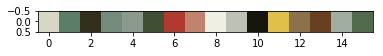

In [173]:
import numpy as np
plt.imshow(np.floor(kmeans.cluster_centers_.reshape((1,16,3))) * (-1))

### Reconstructing

In [176]:
labels = kmeans.labels_
clusters = np.floor(kmeans.cluster_centers_) * (-1)

The data contained in `clusters` and `labels` define the compressed image and should be stored in a proper format, in order to effectively realize the data compression:
* `clusters`: 16 clusters \* 24 bits/cluster
* `labels`: (width x height) px \* 4 bits/px

To reconstruct the image we assign RGB values of the cluster centroids to the pixels and we reshape the matrix in the original form:

In [177]:
# Assigning RGB to clusters and reshaping
pic_recovered = clusters[labels,:].reshape((w,h,3))

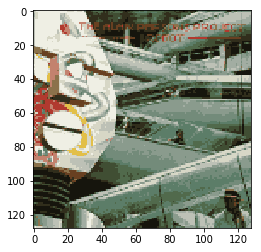

In [181]:
plt.imshow(pic_recovered)

At the cost of a deterioriation in the color quality, the space occupied by the image will be significantly lesser. We can compare the original and the compressed image in the following figure:

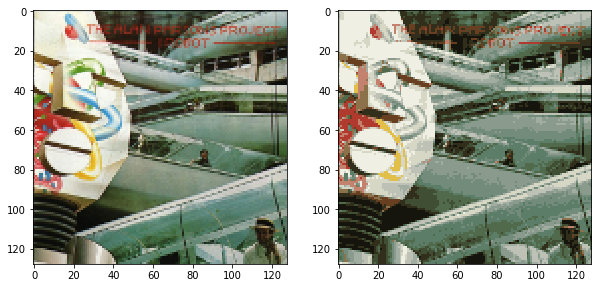

In [182]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10,5))
axes[0].imshow(pic)
axes[1].imshow(pic_recovered)